In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os 
import random
import shutil
import glob

In [ ]:
NB_OF_RACES = 120

In [ ]:
#Create Validation Folder
os.chdir('/content/drive/MyDrive/')
os.getcwd()

if os.path.exists('train_filtered'):
   shutil.rmtree('train_filtered')

if os.path.exists('valid'):
   shutil.rmtree('valid')

os.makedirs('valid')
os.makedirs('train_filtered')

    
# train name in drive

for item in random.sample(glob.glob('images/*'), NB_OF_RACES):

   glob_item = glob.glob(item+'/*')

   valid_percent = int(len(glob_item) - len(glob_item) * 0.6) #take 40% of images
   train_percent = len(glob_item) - valid_percent

   breed_name = item.split('/')[1]
        
   receipt_folder = '/content/drive/MyDrive/valid/' + breed_name
   os.makedirs(receipt_folder)
   
   #  validation folder
   for j in random.sample(glob.glob(item+'/*'), valid_percent):
       shutil.copy(j, receipt_folder)

   receipt_folder = '/content/drive/MyDrive/train_filtered/' + breed_name
   os.makedirs(receipt_folder)
        
   #    train_filtered folder
   for k in random.sample(glob.glob(item+'/*'), train_percent):
           shutil.copy(k, receipt_folder)

In [ ]:
# #Create Validation Folder
# os.chdir('/content/drive/MyDrive/')
# os.getcwd()

# if os.path.isdir('valideee') is False: # just test - will remove it

#     if os.path.exists('train_filtered'):
#         shutil.rmtree('train_filtered')

#     if os.path.exists('valid'):
#         shutil.rmtree('valid')

#     os.makedirs('valid')
#     os.makedirs('train_filtered')

    
#     #train name in drive

#     for item in random.sample(glob.glob('images/*'), NB_OF_RACES):

#         valid_percent = int(len(item) - len(item) * 0.8)
#         train_percent = len(item) - valid_percent

#         breed_name = item.split('/')[1]

#         receipt_folder = '/content/drive/MyDrive/valid/' + breed_name
#         os.makedirs(receipt_folder)

#         #validation folder
#         for j in random.sample(glob.glob(item+'/*'), valid_percent):
#             shutil.move(j, receipt_folder)

#         receipt_folder = '/content/drive/MyDrive/train_filtered/' + breed_name
#         os.makedirs(receipt_folder)
        
#         #train_filtered folder
#         for k in random.sample(glob.glob(item+'/*'), train_percent):
#             shutil.move(k, receipt_folder)

In [ ]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
# result = classifier.predict(grace_hopper[np.newaxis, ...])
# predicted_class = np.argmax(result[0], axis=-1)
# labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# imagenet_labels = np.array(open(labels_path).read().splitlines())
# plt.imshow(grace_hopper)
# plt.axis('off')
# predicted_class_name = imagenet_labels[predicted_class]
# _ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
batch_size = 64
img_height = 224
img_width = 224
data_root = '/content/drive/MyDrive/train_filtered'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8387 files belonging to 120 classes.
Using 6710 files for training.


In [ ]:
# #L'ensemble de données des fleurs comprend cinq classes.
# class_names = np.array(train_ds.class_names)
# print(class_names)

In [ ]:
# Les conventions de TensorFlow Hub pour les modèles d'image 
#sont de s'attendre à des entrées flottantes dans la plage [0, 1] . 
# Utilisez le calque de Rescaling pour y parvenir.

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

zoom_layer = tf.keras.layers.experimental.preprocessing.RandomZoom(.5, .2)
train_ds = train_ds.map(lambda x, y: (zoom_layer(x), y))

# rotation_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2, fill_mode='nearest')
# train_ds = train_ds.map(lambda x, y: (rotation_layer(x), y))

random_translation = tf.keras.layers.experimental.preprocessing.RandomTranslation(
    height_factor = 0.2,
    width_factor = 0.2,
    fill_mode = "reflect",
    interpolation = "bilinear",
    seed = 42
)
train_ds = train_ds.map(lambda x, y: (random_translation(x), y))

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [ ]:
#Exécutez le classificateur sur un lot d'images
result_batch = classifier.predict(train_ds)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Pomeranian', 'Shih-Tzu', 'coyote', ..., 'kelpie',
       'black-and-tan coonhound', 'Eskimo dog'], dtype='<U30')

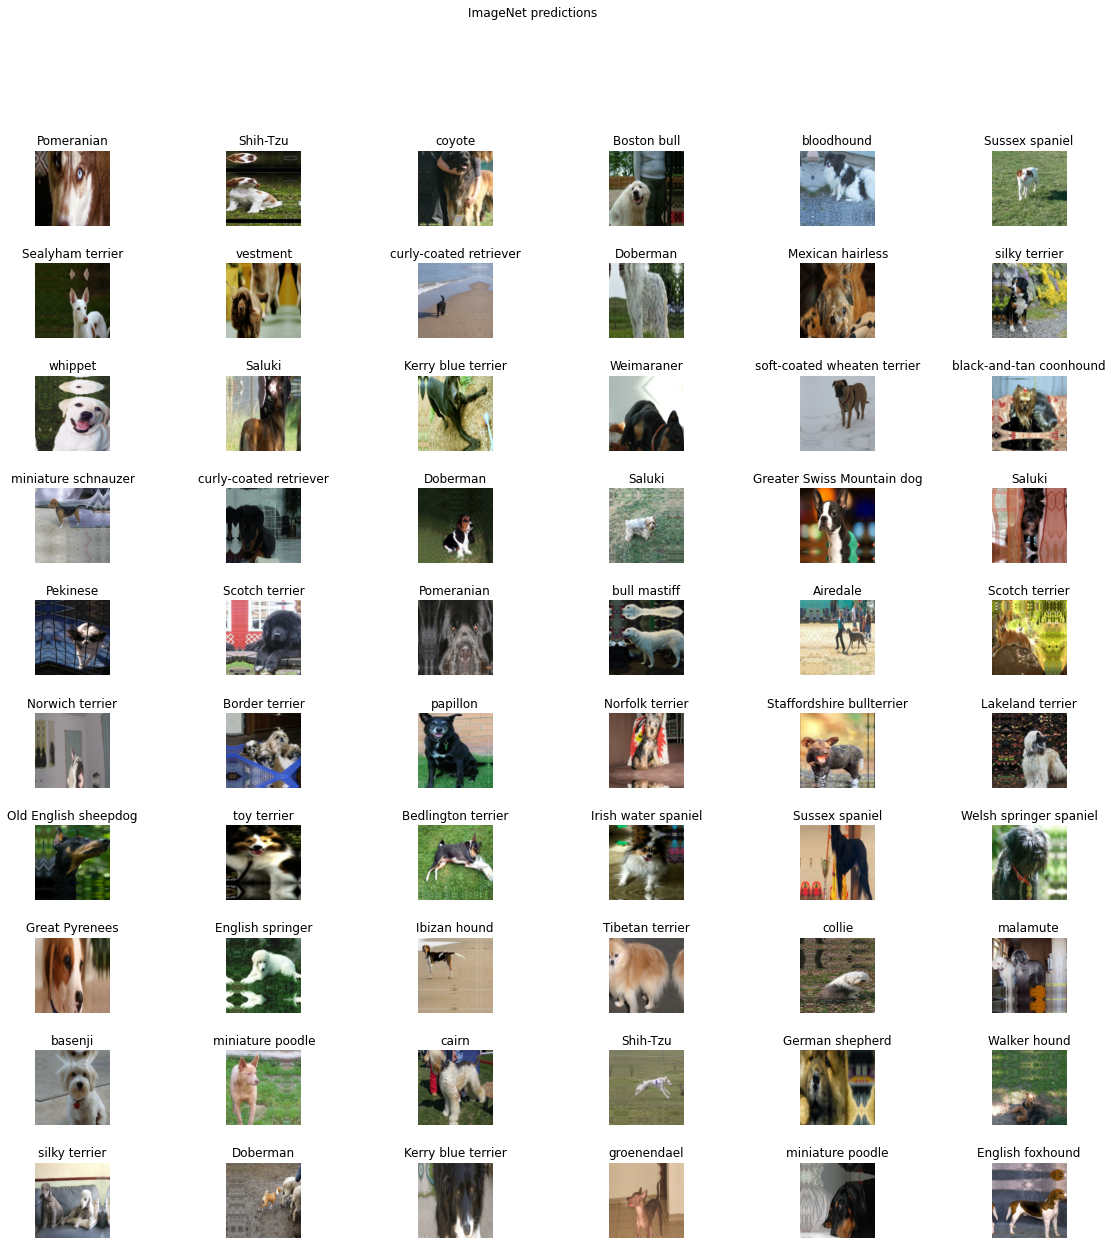

In [ ]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(60):
  plt.subplot(10,6,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


(64, 1280)


In [ ]:
# num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(NB_OF_RACES)
])

model.summary()

predictions = model(image_batch)

predictions.shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


TensorShape([64, 120])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=8,
                    callbacks=[batch_stats_callback])


Epoch 1/8
105/105 [==============================] - 360s 3s/step - loss: 2.4232 - acc: 0.4683
Epoch 2/8
105/105 [==============================] - 355s 3s/step - loss: 1.0093 - acc: 0.7349
Epoch 3/8
105/105 [==============================] - 355s 3s/step - loss: 0.7795 - acc: 0.7780
Epoch 4/8
105/105 [==============================] - 355s 3s/step - loss: 0.6673 - acc: 0.8106
Epoch 5/8
105/105 [==============================] - 358s 3s/step - loss: 0.5992 - acc: 0.8237
Epoch 6/8
105/105 [==============================] - 356s 3s/step - loss: 0.5344 - acc: 0.8441
Epoch 7/8
105/105 [==============================] - 356s 3s/step - loss: 0.4916 - acc: 0.8567
Epoch 8/8
105/105 [==============================] - 359s 3s/step - loss: 0.4581 - acc: 0.8668


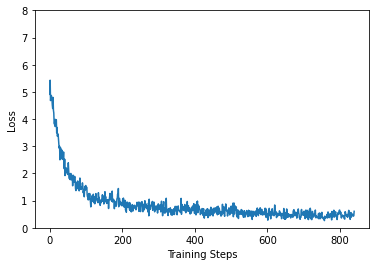

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,8])
plt.plot(batch_stats_callback.batch_losses)


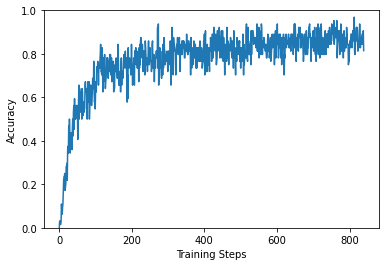

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
print(predicted_id)
predicted_label_batch = predicted_class_names[predicted_id]

[ 97  64 103 105   6  64  22  69  45  77  31  90  57 103  28  83  92  36
  11  83  10  50  44  41   6  93 104  71  26 117  23   4  76  50 119   9
  85   6 101   6  25 100  11  71  11 107  78   9   2  76   9  25 108  40
  30 101  81 116  85  16  56 100  85  65]


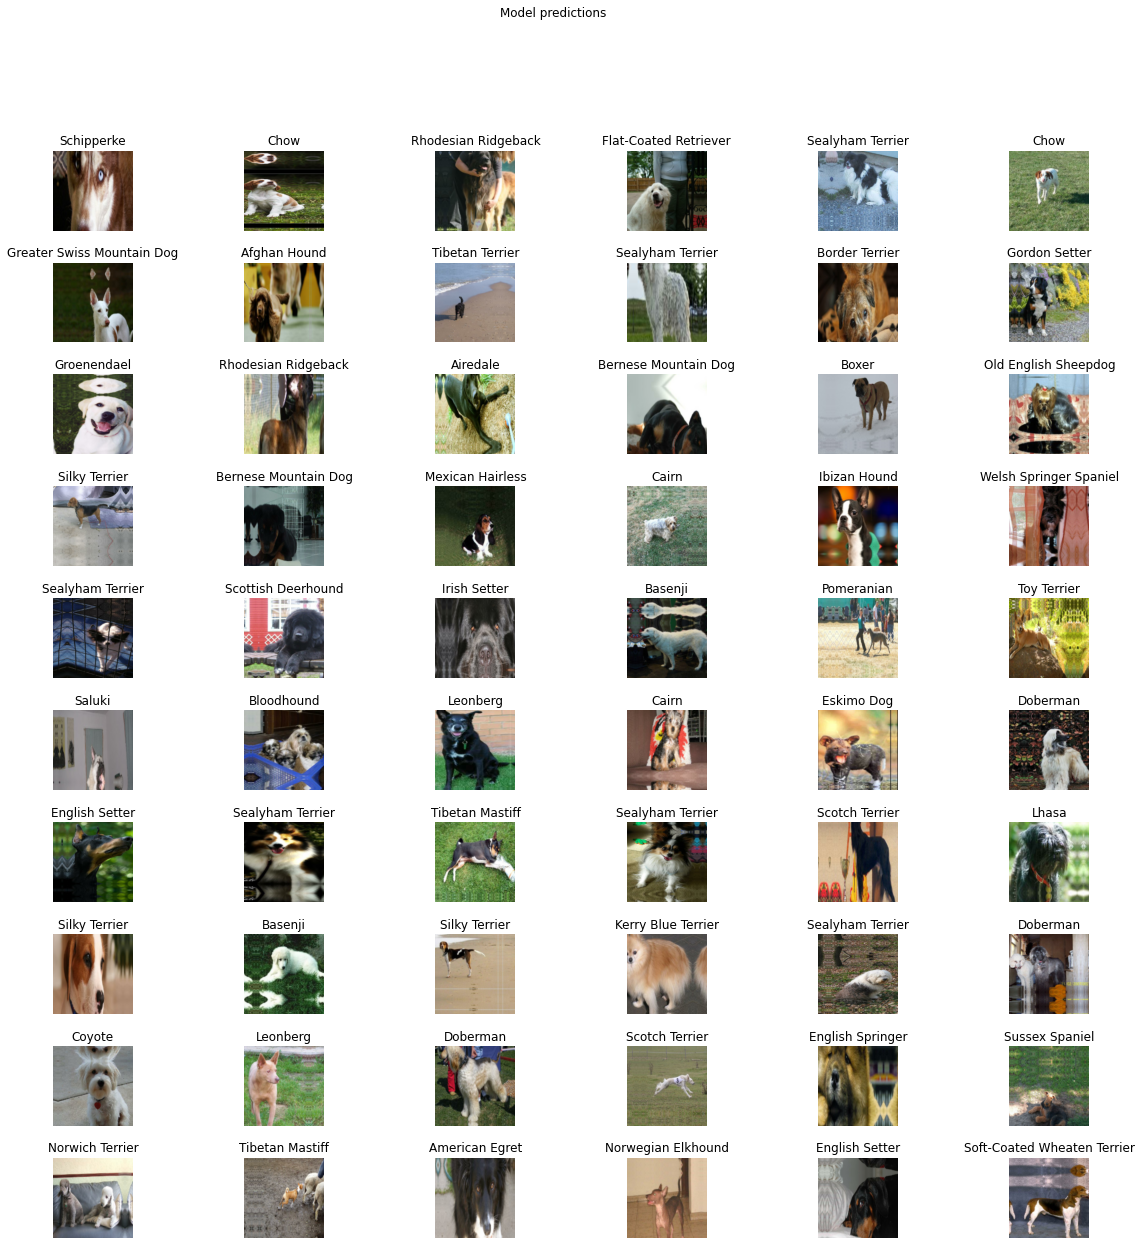

In [ ]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)
for n in range(60):
  plt.subplot(10,6,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")


In [ ]:
loss, acc = model.evaluate(train_ds)
print("Accuracy", acc)

105/105 [==============================] - 365s 3s/step - loss: 0.4169 - acc: 0.8793
Accuracy 0.8792846202850342


In [ ]:

model.save('/content/drive/MyDrive/tl_model', overwrite=True, save_format='h5')